# SINDy-SHRED Applied to Sea Surface Temperature Data

This notebook demonstrates the SINDy-SHRED methodology applied to weekly mean sea-surface temperature (SST) data from the NOAA Optimum Interpolation SST V2 dataset.

## Overview

**SHRED** (SHallow REcurrent Decoder) models combine a recurrent layer (LSTM/GRU) with a shallow decoder network to reconstruct high-dimensional spatio-temporal fields from sensor measurements.

**SINDy-SHRED** extends this by integrating Sparse Identification of Nonlinear Dynamics (SINDy) to learn interpretable governing equations for the latent space dynamics:

$$\dot{z} = \Theta(z) \xi$$

where $z$ is the latent space, $\Theta(z)$ is a library of candidate functions, and $\xi$ is a sparse coefficient matrix.

## Notebook Structure

1. Setup and Imports
2. Data Loading
3. Model Configuration and Training
4. SINDy Discovery
5. Evaluation and Visualization
6. Save Results

## 1. Setup and Imports

In [1]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import loadmat

# Local modules
from sindy_shred import SINDySHRED
from processdata import load_data
import plotting

warnings.filterwarnings("ignore")

# Create results directory
RESULTS_DIR = "results/sst"
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Results will be saved to: {RESULTS_DIR}")

/home/mars/sindy-shred/sindyshred/lib/python3.12/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


Results will be saved to: results/sst


### Device Configuration

Automatically select the best available compute device (CUDA, MPS, or CPU).

In [2]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using device: {device}")

Using device: cuda


### Random Seed

Set random seeds for reproducibility.

In [3]:
SEED = 0

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda":
    torch.cuda.manual_seed(SEED)

## 2. Data Loading

Load the SST dataset and configure sensor locations and trajectory length.

In [4]:
# Load SST data
load_X = load_data('SST')
n = load_X.shape[0]  # Number of time samples
m = load_X.shape[1]  # Spatial dimension

print(f"Data shape: {load_X.shape}")
print(f"Number of time samples: {n}")
print(f"Spatial dimension: {m}")

(1400, 64800)
Data shape: (1400, 44219)
Number of time samples: 1400
Spatial dimension: 44219


### Data and Model Configuration

In [5]:
# Sensor configuration
num_sensors = 250
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

# Trajectory length (52 weeks = 1 year of measurements)
lags = 52

# Data split
train_length = 1000
validate_length = 30

# Time step (weekly data)
dt = 1 / 52.0

# Model hyperparameters
latent_dim = 3
poly_order = 1

# SINDy threshold for sparsity
sindy_threshold = 0.05

print(f"Number of sensors: {num_sensors}")
print(f"Trajectory length (lags): {lags}")
print(f"Training length: {train_length}")
print(f"Latent dimension: {latent_dim}")
print(f"Polynomial order: {poly_order}")

Number of sensors: 250
Trajectory length (lags): 52
Training length: 1000
Latent dimension: 3
Polynomial order: 1


### Visualize Sensor Data

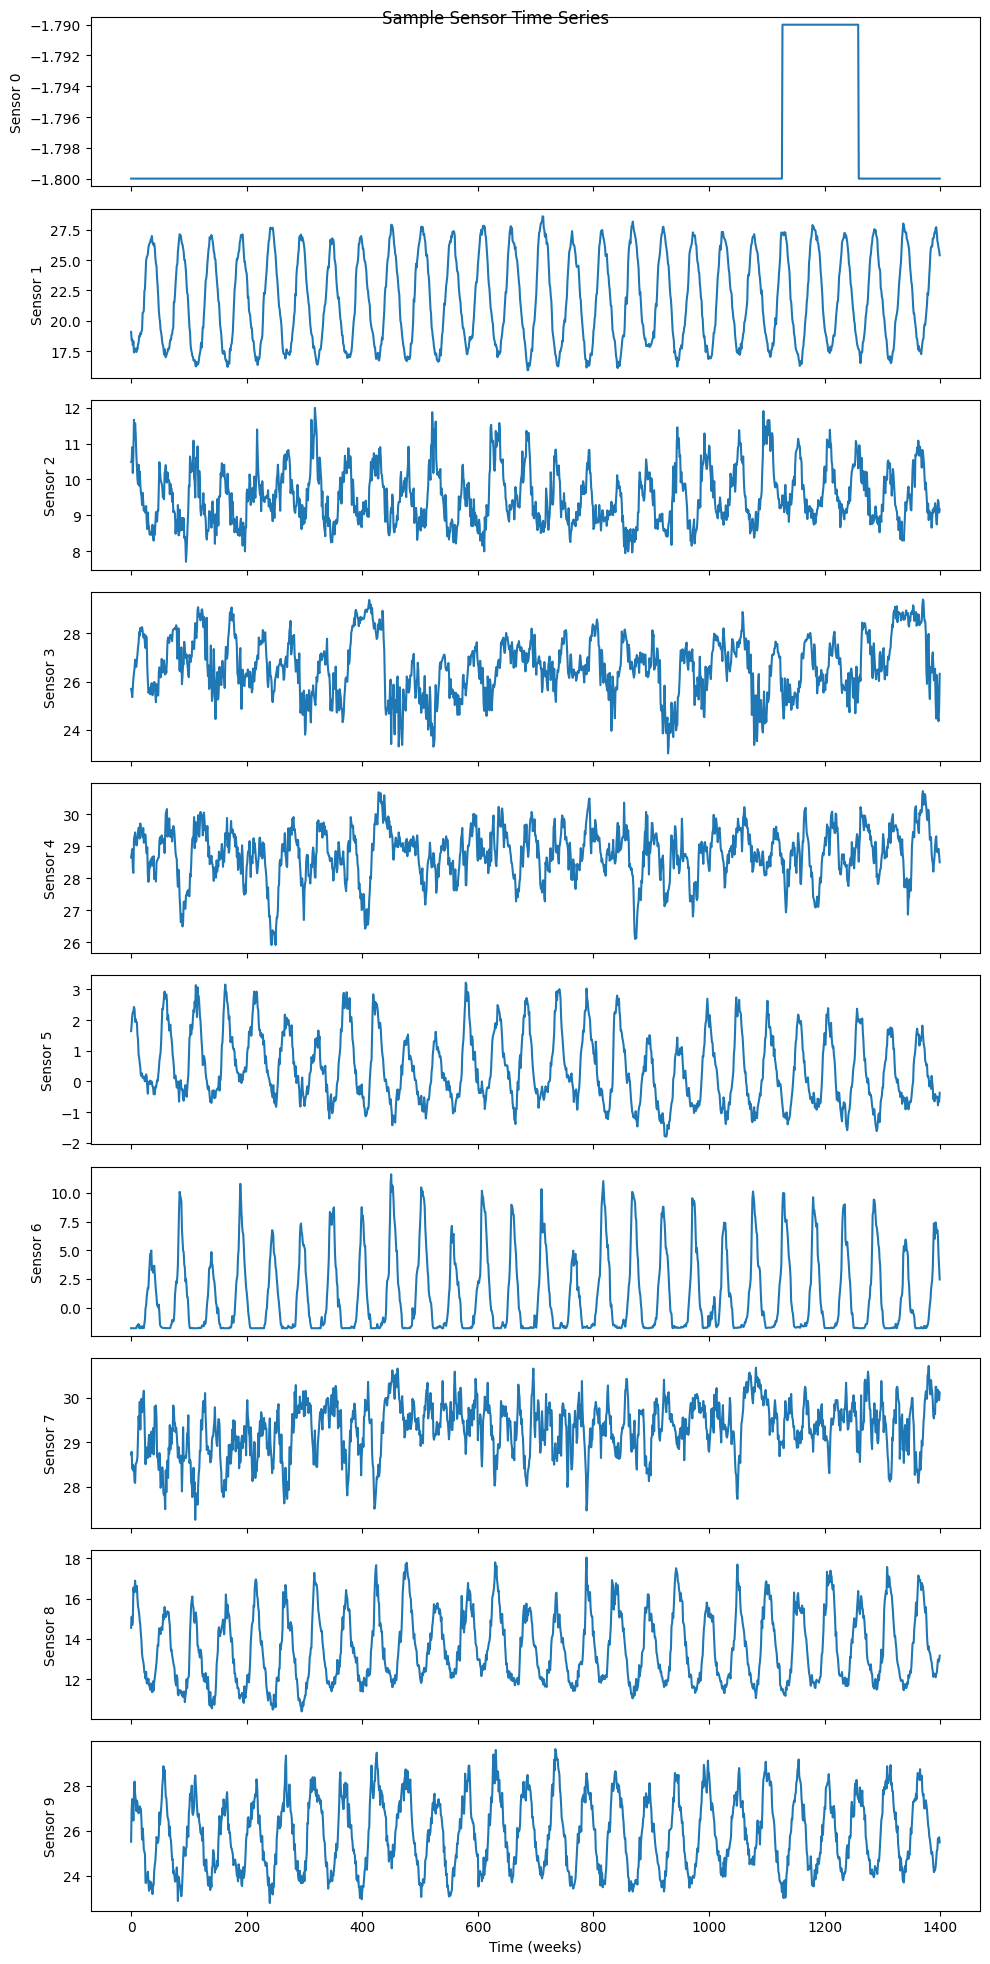

In [6]:
# Plot sample sensor time series
n_sensors_to_plot = min(num_sensors, 10)

fig, axes = plt.subplots(n_sensors_to_plot, 1, figsize=(10, 2 * n_sensors_to_plot), sharex=True)
for i in range(n_sensors_to_plot):
    axes[i].plot(load_X[:, sensor_locations[i]])
    axes[i].set_ylabel(f"Sensor {i}")
axes[-1].set_xlabel("Time (weeks)")
fig.suptitle("Sample Sensor Time Series")
fig.tight_layout()
plt.show()

## 3. Model Configuration and Training

Initialize and train the SINDy-SHRED model using the `SINDySHRED` driver class.

The driver handles:
- Data preprocessing (scaling, train/val/test splits)
- Model initialization
- Training loop with SINDy regularization

In [7]:
# Initialize the SINDy-SHRED driver
model = SINDySHRED(
    latent_dim=latent_dim,
    poly_order=poly_order,
    include_sine=False,
    ode_order=1,  # 1st order ODE: z' = f(z)
    hidden_layers=2,
    l1=350,
    l2=400,
    dropout=0.1,
    batch_size=128,
    num_epochs=200,
    lr=1e-3,
    verbose=True,
    threshold=0.05,
    patience=5,
    sindy_regularization=10.0,
    optimizer="AdamW",
    thres_epoch=100,
    device=device,
)

print("SINDySHRED model initialized")

SINDySHRED model initialized


In [8]:
# Fit the model
# The driver automatically handles data preprocessing and training
model.fit(
    num_sensors=num_sensors,
    dt=dt,
    x_to_fit=load_X,
    lags=lags,
    train_length=train_length,
    validate_length=validate_length,
    sensor_locations=sensor_locations,
    seed=SEED,
)

1 : tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.0594, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.0533, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.0493, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0494, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0496, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0493, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.0493, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.0495, device='cuda:

## 4. SINDy Discovery

Discover sparse governing equations from the learned latent space.

SINDy-derived dynamical equation (1st order):

(x0)' = 0.822 1 + 6.434 x0 + -1.682 x1 + 11.249 x2
(x1)' = -0.489 1 + -6.968 x0 + -0.160 x1 + -5.710 x2
(x2)' = -0.542 1 + -8.236 x0 + -0.308 x1 + -6.315 x2


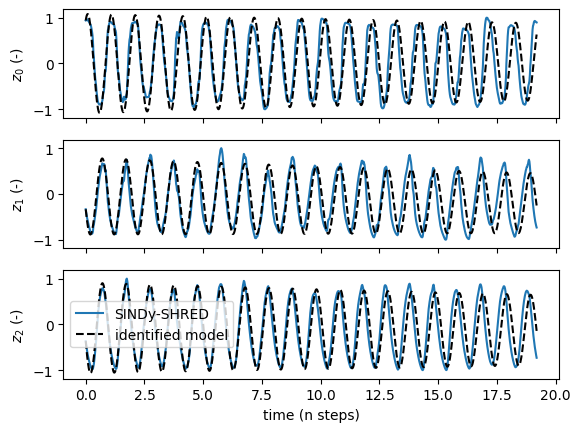

Saved latent comparison plot to results/sst/latent_comparison.pdf


<Figure size 640x480 with 0 Axes>

In [9]:
# Perform SINDy identification on the latent space
model.sindy_identify(threshold=sindy_threshold, plot_result=True)
fig = plt.gcf()
fig.suptitle("Latent Space: SINDy-SHRED vs Identified Model")
fig.tight_layout()

# Save the latent comparison plot
fig.savefig(f"{RESULTS_DIR}/latent_comparison.pdf", bbox_inches="tight", dpi=300)
fig.savefig(f"{RESULTS_DIR}/latent_comparison.png", bbox_inches="tight", dpi=300)
print(f"Saved latent comparison plot to {RESULTS_DIR}/latent_comparison.pdf")

plt.show()

## 5. Evaluation and Visualization

Evaluate reconstruction performance on the test set.

### Reconstruction Error

In [10]:
# Compute test reconstruction error using new API
test_recons = model.sensor_recon(data_type="test", return_scaled=False)
test_ground_truth = model._scaler.inverse_transform(
    model._test_data.Y.detach().cpu().numpy()
)

relative_error = model.relative_error(test_recons, test_ground_truth)
print(f"Test set relative reconstruction error: {relative_error:.4f}")

Test set relative reconstruction error: 0.0443


### SINDy Model Prediction

Use the discovered SINDy model to predict latent trajectories and decode back to spatial domain.

In [11]:
# Predict latent trajectories using the discovered SINDy model
x_predict = model.predict_latent()  # Alias for sindy_predict()

# Decode SINDy predictions to spatial domain using new API
output_sindy = model.decode_to_physical(x_predict)  # Alias for shred_decode()

# Or use the convenience method:
# output_sindy = model.forecast(init_from="test", return_scaled=True)

print(f"SINDy prediction shape: {x_predict.shape}")
print(f"Decoded output shape: {output_sindy.shape}")

SINDy prediction shape: (318, 3)
Decoded output shape: (318, 44219)


### Spatial Reconstruction Comparison

In [12]:
# Load SST location indices for visualization
load_X_full = loadmat('Data/SST_data.mat')['Z'].T
mean_X = np.mean(load_X_full, axis=0)
sst_locs = np.where(mean_X != 0)[0]

Saved spatial comparison plot to results/sst/spatial_comparison.pdf


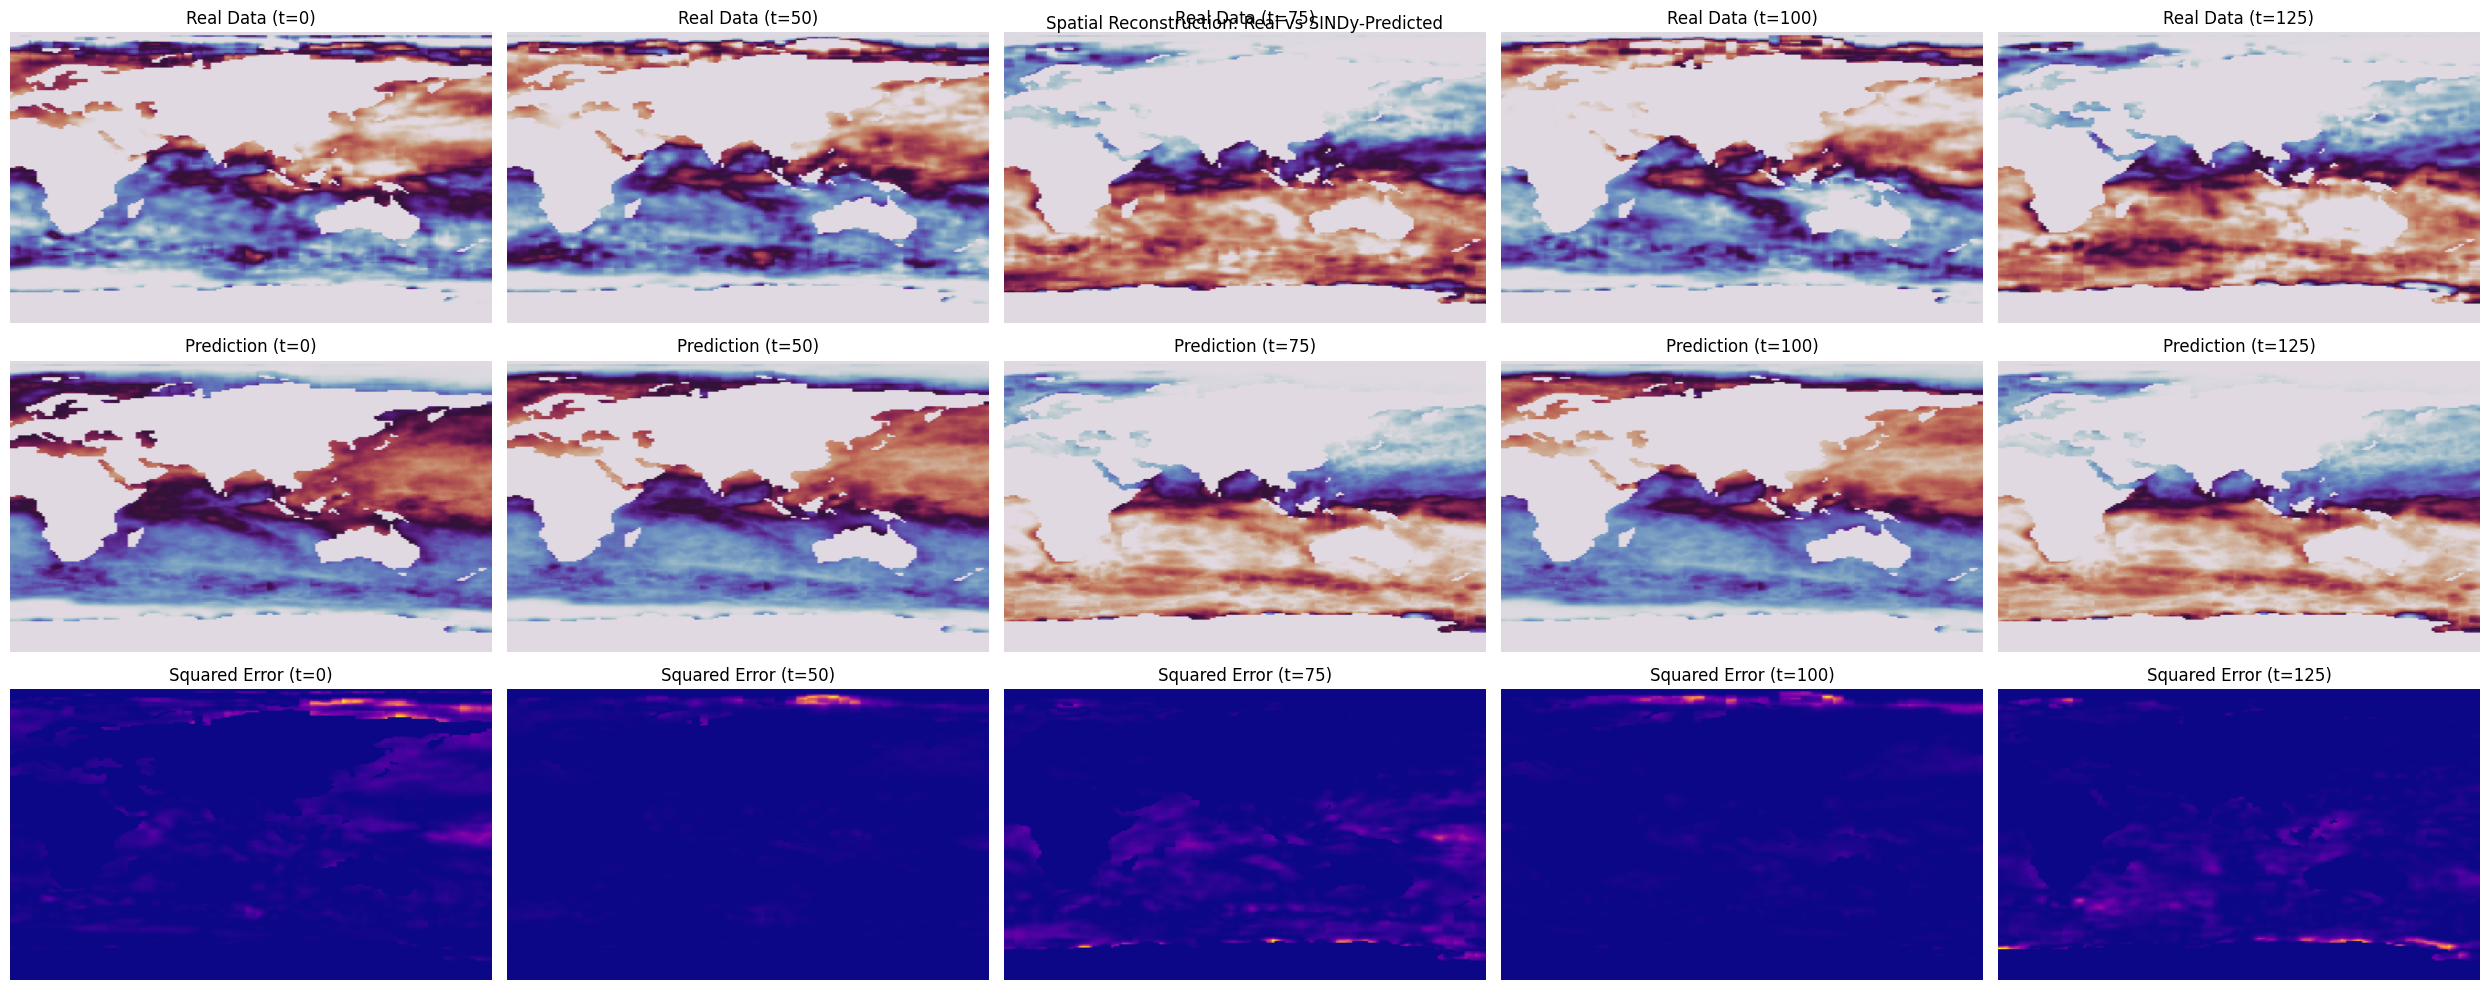

In [13]:
# Compare reconstructions at selected timesteps
timesteps = [0, 50, 75, 100, 125]

# Use the test data ground truth
test_Y = model._test_data.Y.detach().cpu().numpy()

fig, axes = plotting.plot_reconstruction_comparison(
    test_Y,
    output_sindy,
    timesteps,
    sst_locs=sst_locs,
    lat_range=(0, 180),
    lon_range=(0, 180),
    diff_scale=10
)
fig.suptitle("Spatial Reconstruction: Real vs SINDy-Predicted")

# Save the spatial comparison plot
fig.savefig(f"{RESULTS_DIR}/spatial_comparison.pdf", bbox_inches="tight", dpi=300)
fig.savefig(f"{RESULTS_DIR}/spatial_comparison.png", bbox_inches="tight", dpi=300)
print(f"Saved spatial comparison plot to {RESULTS_DIR}/spatial_comparison.pdf")

plt.show()

### Sensor-Level Predictions

Saved sensor predictions plot to results/sst/sensor_predictions_grid.pdf


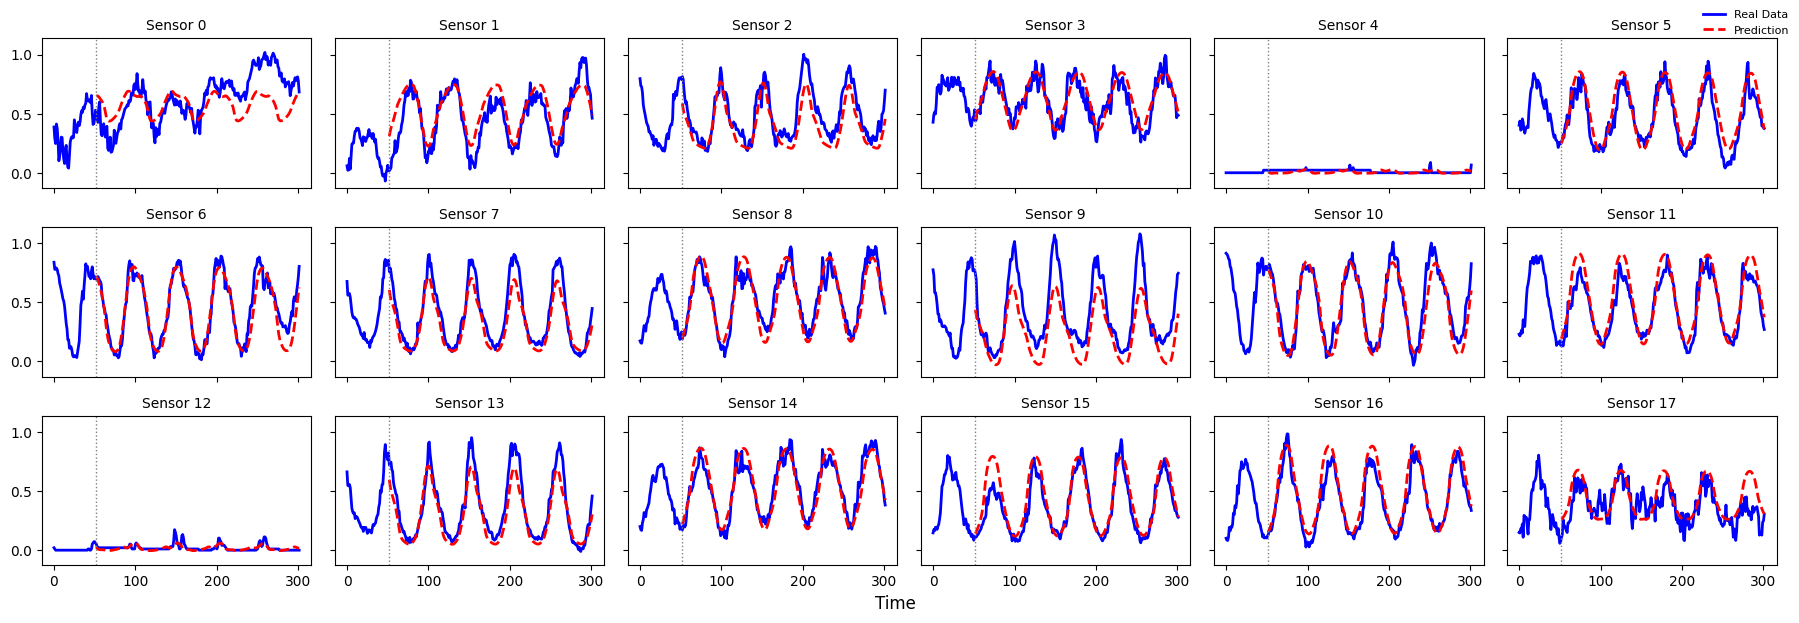

In [14]:
# Select random sensor locations for visualization
sensor_locations_viz = np.random.randint(1, 40000, size=18)
sensor_indices = list(range(18))

fig, axes = plotting.plot_sensor_predictions(
    test_Y,
    output_sindy,
    sensor_locations=sensor_locations_viz,
    sensor_indices=sensor_indices,
    num_context=lags,  # Show context period before predictions
    num_pred=min(250, len(output_sindy) - lags),
    rows=3,
    cols=6,
    save_path=f"{RESULTS_DIR}/sensor_predictions_grid.pdf"
)
print(f"Saved sensor predictions plot to {RESULTS_DIR}/sensor_predictions_grid.pdf")
plt.show()

### Latent Space Analysis

Visualize the latent space trajectories for the test set.

Saved latent trajectories plot to results/sst/latent_trajectories.pdf


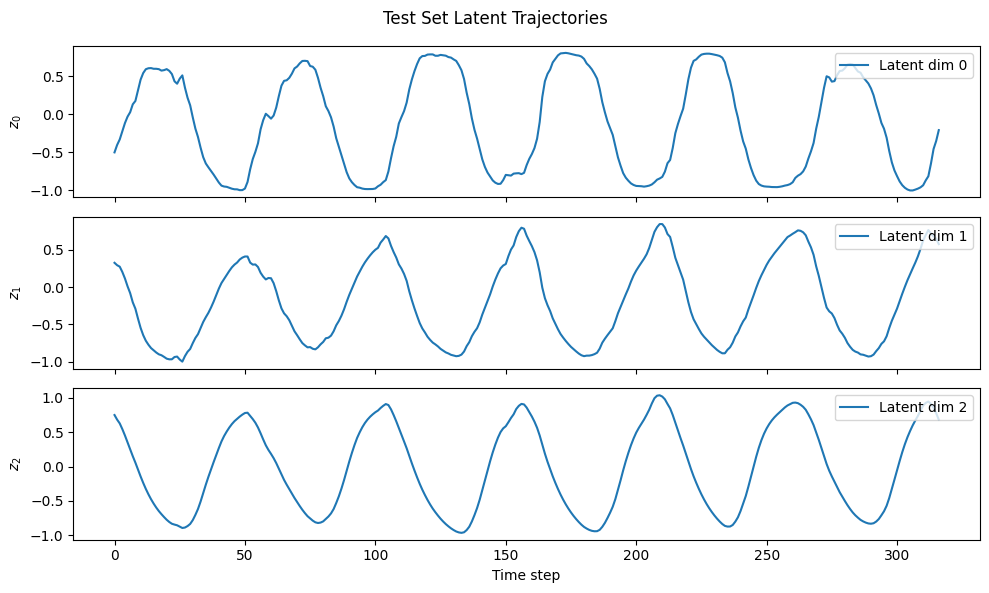

In [15]:
# Get normalized latent trajectories for test data
gru_outs_test = model.gru_normalize(data_type="test")
gru_outs_test_np = gru_outs_test.detach().cpu().numpy()

# Also get training latent trajectories
gru_outs_train = model.gru_normalize(data_type="train")
gru_outs_train_np = gru_outs_train.detach().cpu().numpy()

# Plot latent trajectories
fig, axes = plt.subplots(latent_dim, 1, figsize=(10, 2 * latent_dim), sharex=True)
for i in range(latent_dim):
    axes[i].plot(gru_outs_test_np[:, i], label=f'Latent dim {i}')
    axes[i].set_ylabel(f'$z_{i}$')
    axes[i].legend(loc='upper right')
axes[-1].set_xlabel('Time step')
fig.suptitle('Test Set Latent Trajectories')
fig.tight_layout()

# Save the latent trajectories plot
fig.savefig(f"{RESULTS_DIR}/latent_trajectories.pdf", bbox_inches="tight", dpi=300)
fig.savefig(f"{RESULTS_DIR}/latent_trajectories.png", bbox_inches="tight", dpi=300)
print(f"Saved latent trajectories plot to {RESULTS_DIR}/latent_trajectories.pdf")

plt.show()

## Summary

This notebook demonstrated the SINDy-SHRED methodology on SST data using the `SINDySHRED` driver class:

1. Loaded weekly SST data from NOAA
2. Configured sensor locations and model hyperparameters
3. Trained a SINDy-SHRED model using the driver interface
4. Discovered sparse governing equations for the latent dynamics
5. Evaluated reconstruction quality and visualized results
6. **Saved all results** to the `results/sst/` folder

### Saved Files

| File | Description |
|------|-------------|
| `shred_model.pt` | Trained SHRED neural network weights |
| `latent_train.npy` | Latent trajectories from training data |
| `latent_test.npy` | Latent trajectories from test data |
| `latent_sindy_predict.npy` | SINDy-predicted latent trajectories |
| `sindy_coefficients.npy` | Learned SINDy coefficient matrix |
| `sindy_feature_names.txt` | Names of SINDy library terms |
| `config.npy` | Model configuration and hyperparameters |
| `*.pdf/*.png` | Visualization plots |

The `SINDySHRED` driver simplifies the workflow by handling:
- Data preprocessing and scaling
- Train/validation/test splits
- Model initialization and training
- Post-hoc SINDy identification
- Latent space decoding

## 6. Save Results

Save the trained model, latent space values, and learned SINDy model to the results folder.

In [16]:
# Save the trained SHRED model
torch.save(model._shred.state_dict(), f"{RESULTS_DIR}/shred_model.pt")
print(f"Saved SHRED model to {RESULTS_DIR}/shred_model.pt")

# Save latent space trajectories
np.save(f"{RESULTS_DIR}/latent_train.npy", gru_outs_train_np)
np.save(f"{RESULTS_DIR}/latent_test.npy", gru_outs_test_np)
np.save(f"{RESULTS_DIR}/latent_sindy_predict.npy", x_predict)
print(f"Saved latent trajectories to {RESULTS_DIR}/latent_*.npy")

# Save SINDy model coefficients
sindy_coefficients = model._model.coefficients()
np.save(f"{RESULTS_DIR}/sindy_coefficients.npy", sindy_coefficients)
print(f"Saved SINDy coefficients to {RESULTS_DIR}/sindy_coefficients.npy")
print(f"SINDy coefficients shape: {sindy_coefficients.shape}")

# Save SINDy feature names
feature_names = model._model.get_feature_names()
with open(f"{RESULTS_DIR}/sindy_feature_names.txt", "w") as f:
    for name in feature_names:
        f.write(name + "\n")
print(f"Saved SINDy feature names to {RESULTS_DIR}/sindy_feature_names.txt")

# Save configuration
config = {
    "latent_dim": latent_dim,
    "poly_order": poly_order,
    "num_sensors": num_sensors,
    "lags": lags,
    "train_length": train_length,
    "validate_length": validate_length,
    "dt": dt,
    "sindy_threshold": sindy_threshold,
    "relative_error": relative_error,
}
np.save(f"{RESULTS_DIR}/config.npy", config)
print(f"Saved configuration to {RESULTS_DIR}/config.npy")

# Print summary of saved files
print("\n" + "="*50)
print("Saved files summary:")
print("="*50)
for f in sorted(os.listdir(RESULTS_DIR)):
    fpath = os.path.join(RESULTS_DIR, f)
    size = os.path.getsize(fpath)
    print(f"  {f}: {size/1024:.1f} KB")

Saved SHRED model to results/sst/shred_model.pt
Saved latent trajectories to results/sst/latent_*.npy
Saved SINDy coefficients to results/sst/sindy_coefficients.npy
SINDy coefficients shape: (3, 4)
Saved SINDy feature names to results/sst/sindy_feature_names.txt
Saved configuration to results/sst/config.npy

Saved files summary:
  .gitkeep: 0.0 KB
  config.npy: 0.6 KB
  latent_comparison.pdf: 9.5 KB
  latent_comparison.png: 18.6 KB
  latent_sindy_predict.npy: 7.6 KB
  latent_test.npy: 3.8 KB
  latent_train.npy: 11.8 KB
  latent_trajectories.pdf: 21.2 KB
  latent_trajectories.png: 334.4 KB
  sensor_predictions_grid.pdf: 82.2 KB
  shred_model.pt: 69832.3 KB
  sindy_coefficients.npy: 0.2 KB
  sindy_feature_names.txt: 0.0 KB
  spatial_comparison.pdf: 785.9 KB
  spatial_comparison.png: 905.0 KB
